In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hieutrungnguyen","key":"25a684d95896d77470b17ee2267c475f"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download shubhamgoel27/dermnet

100% 1.71G/1.72G [00:43<00:00, 55.8MB/s]
100% 1.72G/1.72G [00:43<00:00, 42.4MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('/content/dermnet.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dermnet')

IMPORT CÁC THƯ VIỆN CẦN THIẾT

In [ ]:
import glob
import os.path as osp
import random
import numpy as np
from PIL import Image
import os
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
from torch.utils.data import ConcatDataset, WeightedRandomSampler
import torchvision.datasets as datasets

from tqdm import tqdm

from sklearn.model_selection import train_test_split, KFold, ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import time
import copy

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

resize = (224, 224)
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]

TẠO CLASS TRANSFORM ĐỂ TIỀN XỬ LÝ DỮ LIỆU

In [ ]:
from torchvision.transforms.transforms import RandomVerticalFlip

class ImageTransform():
  def __init__(self, resize, mean, std):
    self.data_transform = {
        'augment': transforms.Compose([
                                    transforms.Resize(resize),                         
                                    transforms.RandomHorizontalFlip(0.5),
                                    transforms.RandomVerticalFlip(0.5),
                                    transforms.RandomRotation(20),
                                    transforms.ColorJitter(brightness=1, contrast=0.1, hue=0.4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)
        ]),

        'val': transforms.Compose([transforms.Resize(resize),
                                   transforms.CenterCrop(resize),                                
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean, std)
        ]),

        'test': transforms.Compose([
                                    transforms.Resize(resize),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)
        ]),

        'original': transforms.Compose([
                                      transforms.Resize(resize),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
        ])

    }

  def __call__(self, image, phase=None):
    #image = Image(file_list)
    return self.data_transform[phase](image)        

HÀM NÀY DÙNG ĐỂ TẠO LIST ĐƯỜNG DẪN ẢNH TỪ FOLDER DATASET

In [ ]:
def make_datapath_list(phase=None):
  rootpath = '/content/dermnet/'
  target_path = osp.join(rootpath + phase + '/**/*.jpg')
  
  path_list = list()

  for path in glob.glob(target_path):
    path_list.append(path)

  return path_list

DISEASES DICTIONARY VÀ LIST

In [ ]:
disease_dict_1 = {
    'Atopic Dermatitis Photos': 0,
    'Eczema Photos': 1,
    'Psoriasis pictures Lichen Planus and related diseases': 2
}

disease_list_1 = {'Atopic Dermatitis Photos', 'Eczema Photos', 'Psoriasis pictures Lichen Planus and related diseases'}

disease_dict_2 = {
    'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 0,
    'Nail Fungus and other Nail Disease': 1,
    'Warts Molluscum and other Viral Infections': 2
}

disease_list_2 = {'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
    'Nail Fungus and other Nail Disease',
    'Warts Molluscum and other Viral Infections'}

CLASS DATASET DÙNG ĐỂ TẠO DATASET

In [ ]:
class MyDataset(data.Dataset):
  def __init__(self, file_list, disease_dict, transform=None, phase=None):
    self.file_list = file_list
    self.transform = transform
    self.phase = phase
    self.disease_dict = disease_dict
    
  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, index):
    image_path = self.file_list[index]
    image = Image.open(image_path)

    image_transformed = self.transform(image, self.phase)

    name = image_path.split('/')[-2]
    #labels = torch.tensor(int(self.disease_dict[name]))
    labels = self.disease_dict[name]

    return  image_transformed, labels

ĐÂY LÀ HÀM LỌC RA NHỮNG ĐƯỜNG DẪN ẢNH THUỘC VỀ 3 LOẠI BỆNH QUAN TÂM

In [ ]:
#lọc ra danh sách đường dẫn 3 loại bệnh quan tâm
def image_class_filter(train_list, disease_list, phase=None):
  new_train_list = list()
  root_train = '/content/dermnet/' + phase + '/'
  for disease in disease_list:
    train_path = osp.join(root_train + disease)
    for path in glob.glob(train_path + '/*.jpg'):
      new_train_list.append(path)
  return new_train_list

TẠO DANH SÁCH TRAIN, VAL, TEST

In [ ]:
#tạo danh sách train, val, test

train_list = make_datapath_list('train')
test_list = make_datapath_list('test')

train_list = image_class_filter(train_list, disease_list_2, phase='train')
test_list = image_class_filter(test_list, disease_list_2, phase='test')
train_list, val_list = train_test_split(train_list, test_size=0.2)


In [ ]:
print(len(train_list))

2620


TẠO DATASET VÀ DATA LOADER ĐỂ ĐƯA VÀO HUẤN LUYỆN

In [ ]:

#tạo dataset
train_dataset_original = MyDataset(train_list, disease_dict_2, transform=ImageTransform(resize, mean, std), phase='original')
train_dataset_augment = MyDataset(train_list, disease_dict_2, transform=ImageTransform(resize, mean, std), phase='augment')
val_dataset = MyDataset(val_list, disease_dict_2, transform=ImageTransform(resize,mean, std), phase='val')
test_dataset = MyDataset(test_list, disease_dict_2, transform=ImageTransform(resize, mean, std), phase='test')

train_dataset = ConcatDataset([train_dataset_augment, train_dataset_original])

#train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [5000, 1258])
#tạo dataloader để đưa vào huấn luyện 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

#tạo dataloader dict
data_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

In [ ]:
def set_parameter_requires_grad(model_ft, feature_extracting=True):
  if feature_extracting:
    for param in model_ft.parameter():
      param.requires_grad = False

HÀM KHỞI TẠO MÔ HÌNH

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
  model_ft = None
  input_size = 0

  if model_name == 'resnet':
    model_ft = models.resnet50(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224

  elif model_name == 'squeezenet':
    model_ft = models.squeezenet1_0(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    model_ft.num_classes = num_classes
    input_size = 224

  elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

  elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

  else:
        print("Invalid model name, exiting...")
        exit()

  return model_ft, input_size


CLASS EARLY STOPPING: QUYẾT ĐỊNH DỪNG HUẤN LUYỆN SAU 1 LƯỢNG EPOCH MÀ VALIDATION LOSS KHÔNG ĐƯỢC CẢI THIỆN (KHÔNG GIẢM)

In [ ]:
class EarlyStopping:
  def __init__(self, patience=7, verbose=False, delta=0, path='/content/drive/MyDrive/MQ ICT/Densenet/earlyStopping/current_checkpoint_augmentation.pt', trace_func=print):
      """
        Args:
            patience (int): thời gian đợi kể từ lần cuối validation loss giảm
                            mặc định: 7
            verbose (bool): nếu True, in một thông báo cho mỗi lần cải thiện validation loss
                            Default: False
            delta (float): Thay đổi tối thiểu về số lượng được giám sát để đủ điều kiện là một cải tiến.
                            Default: 0
            path (str): đưỡng dẫn tới file checkpoint.
                          
            trace_func (function): hàm in dấu vết
                            Default: print            
        """

      self.patience = patience
      self.verbose = verbose
      self.counter = 0
      self.best_score = None
      self.early_stop = False
      self.val_loss_min = np.Inf
      self.delta = delta
      self.path = path
      self.trace_func = trace_func

  def __call__(self, val_loss, model):

     score = -val_loss

     if self.best_score is None:
        self.best_score = score
        self.save_checkpoint(val_loss, model)
     elif score < self.best_score + self.delta:
        self.counter += 1
        self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
        if self.counter >= self.patience:
            self.early_stop = True
     else:
        self.best_score = score
        self.save_checkpoint(val_loss, model)
        self.counter = 0

  def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

HÀM HUẤN LUYỆN MÔ HÌNH

In [ ]:
def train(start_epoch, n_epochs, val_loss_min, loaders, model, criterion, optimizer, patience):
  #print('begin')
  # to track the training loss as the model trains
  train_losses = []
  # to track the validation loss as the model trains
  valid_losses = []
  # to track the average training loss per epoch as the model trains
  avg_train_losses = []
  # to track the average validation loss per epoch as the model trains
  avg_valid_losses = []

  train_acc = []
  valid_acc = []
  avg_train_acc = []
  avg_valid_acc = []
  
  early_stopping = EarlyStopping(patience=patience, verbose=True)

  #print("early stop")
  for epoch in range(start_epoch, n_epochs+1):
    #training
    #print("training")
    model.train()
    for bacth_index, (images, labels) in enumerate(loaders['train']):
      N = images.size(0)
      #print("tiếp tục")
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      predictions = outputs.max(1, keepdim=True)[1]

      train_losses.append(loss.item())
      train_acc.append(predictions.eq(labels.view_as(predictions)).sum().item()/N)
    #validation
    model.eval()
    with torch.no_grad():
      for batch_index, (images, labels) in enumerate(loaders['val']):
        N = images.size(0)
        outputs = model(images)
        loss = criterion(outputs, labels)
        predictions = outputs.max(1, keepdim=True)[1]
        
        valid_losses.append(loss.item())
        valid_acc.append(predictions.eq(labels.view_as(predictions)).sum().item()/N)

    # print training/validation statistics 
    # calculate average loss over an epoch

    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    train = np.average(train_acc)
    valid = np.average(valid_acc)
    avg_train_acc.append(train)
    avg_valid_acc.append(valid)
    
    epoch_len = len(str(n_epochs))
        
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss': valid_loss,
        'avg_train_loss': avg_train_losses,
        'avg_valid_loss': avg_valid_losses,
        'avg_train_acc': avg_train_acc,
        'avg_valid_acc': avg_valid_acc,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }

    torch.save(checkpoint, '/content/drive/MyDrive/MQ ICT/Densenet/earlyStopping/checkpoint_augmentation.pt')
    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'train_acc: {train:.5f}'  +
                     f'valid_loss: {valid_loss:.5f}'  
                     f'valid_acc: {valid:.5f}'
                 )
        
    print(print_msg)
        
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    train_acc = []
    valid_acc = []

    early_stopping(valid_loss, model)
        
    if early_stopping.early_stop:
            print("Early stopping")
            break

  return model, avg_train_losses, avg_valid_losses, avg_train_acc, avg_valid_acc

Huấn luyện với tập dữ liệu chưa augmentation


In [ ]:
num_epochs = 100
model_ft, size = initialize_model(model_name='densenet', num_classes=3, feature_extract=False, use_pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.Reduc

trained_model, avg_train_losses, avg_valid_losses, avg_train_acc, avg_valid_acc = train(start_epoch=1, 
                                                                                        n_epochs=num_epochs, 
                                                                                        val_loss_min=np.Inf, 
                                                                                        loaders=data_loaders, 
                                                                                        model=model_ft, 
                                                                                        criterion=criterion, 
                                                                                        optimizer=optimizer,
                                                                                        patience=5
                                                                                        )

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

[  1/100] train_loss: 0.54433 train_acc: 0.77210valid_loss: 0.41765valid_acc: 0.84315
Validation loss decreased (inf --> 0.417646).  Saving model ...
[  2/100] train_loss: 0.33270 train_acc: 0.87206valid_loss: 0.36015valid_acc: 0.87609
Validation loss decreased (0.417646 --> 0.360147).  Saving model ...
[  3/100] train_loss: 0.23531 train_acc: 0.91077valid_loss: 0.32170valid_acc: 0.86310
Validation loss decreased (0.360147 --> 0.321697).  Saving model ...
[  4/100] train_loss: 0.20125 train_acc: 0.92411valid_loss: 0.30382valid_acc: 0.88204
Validation loss decreased (0.321697 --> 0.303825).  Saving model ...
[  5/100] train_loss: 0.15054 train_acc: 0.94817valid_loss: 0.29792valid_acc: 0.88968
Validation loss decreased (0.303825 --> 0.297924).  Saving model ...
[  6/100] train_loss: 0.11790 train_acc: 0.96113valid_loss: 0.31673valid_acc: 0.89712
EarlyStopping counter: 1 out of 5
[  7/100] train_loss: 0.10680 train_acc: 0.96031valid_loss: 0.33237valid_acc: 0.90030
EarlyStopping counter: 2

In [ ]:
trained_model.load_state_dict(torch.load('/content/drive/MyDrive/MQ ICT/Densenet/earlyStopping/current_checkpoint.pt'))

<All keys matched successfully>

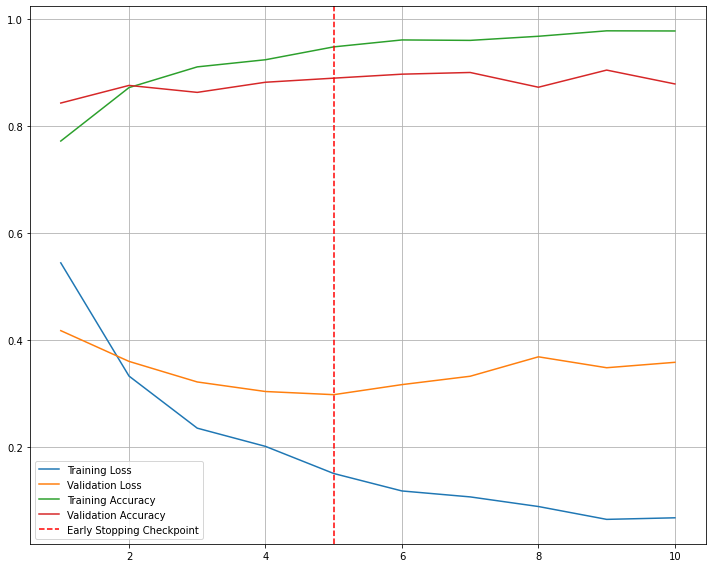

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')
plt.plot(range(1,len(avg_train_acc)+1),avg_train_acc, label='Training Accuracy')
plt.plot(range(1,len(avg_valid_acc)+1),avg_valid_acc,label='Validation Accuracy')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

#plt.xlabel('epochs')
#plt.ylabel('loss')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

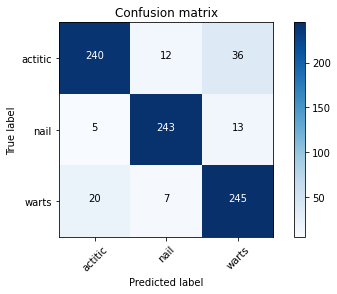

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools

def plot_cf_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

trained_model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(data_loaders['test']):
        images, labels = data
        N = images.size(0)
        outputs = trained_model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.numpy())
        y_predict.extend(np.squeeze(prediction.numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['actitic', 'nail', 'warts']
plot_cf_matrix(confusion_mtx, plot_labels)



In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

     actitic       0.91      0.83      0.87       288
        nail       0.93      0.93      0.93       261
       warts       0.83      0.90      0.87       272

    accuracy                           0.89       821
   macro avg       0.89      0.89      0.89       821
weighted avg       0.89      0.89      0.89       821



In [ ]:
def train_v2(start_epoch, n_epochs, val_loss_min, loaders, model, criterion, optimizer, patience, scheduler):
  #print('begin')
  # to track the training loss as the model trains
  train_losses = []
  # to track the validation loss as the model trains
  valid_losses = []
  # to track the average training loss per epoch as the model trains
  avg_train_losses = []
  # to track the average validation loss per epoch as the model trains
  avg_valid_losses = []

  train_acc = []
  valid_acc = []
  avg_train_acc = []
  avg_valid_acc = []
  
  early_stopping = EarlyStopping(patience=patience, verbose=True)
  #print("early stop")
  for epoch in range(start_epoch, n_epochs+1):
    #training
    #print("training")
    model.train()
    for bacth_index, (images, labels) in enumerate(loaders['train']):
      N = images.size(0)
      #print("tiếp tục")
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      predictions = outputs.max(1, keepdim=True)[1]

      train_losses.append(loss.item())
      train_acc.append(predictions.eq(labels.view_as(predictions)).sum().item()/N)
    #validation
    model.eval()
    with torch.no_grad():
      for batch_index, (images, labels) in enumerate(loaders['val']):
        N = images.size(0)
        outputs = model(images)
        loss = criterion(outputs, labels)
        predictions = outputs.max(1, keepdim=True)[1]
        
        valid_losses.append(loss.item())
        valid_acc.append(predictions.eq(labels.view_as(predictions)).sum().item()/N)

    # print training/validation statistics 
    # calculate average loss over an epoch


    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    train = np.average(train_acc)
    valid = np.average(valid_acc)
    avg_train_acc.append(train)
    avg_valid_acc.append(valid)
    
    scheduler.step(train_loss)

    epoch_len = len(str(n_epochs))
        
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss': valid_loss,
        'avg_train_loss': avg_train_losses,
        'avg_valid_loss': avg_valid_losses,
        'avg_train_acc': avg_train_acc,
        'avg_valid_acc': avg_valid_acc,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }

    torch.save(checkpoint, '/content/drive/MyDrive/MQ ICT/Densenet/earlyStopping/checkpoint_2.pt')
    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'train_acc: {train:.5f}'  +
                     f'valid_loss: {valid_loss:.5f}'  
                     f'valid_acc: {valid:.5f}'
                 )
        
    print(print_msg)
        
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    train_acc = []
    valid_acc = []

    early_stopping(valid_loss, model)
        
    if early_stopping.early_stop:
            print("Early stopping")
            break

  return model, avg_train_losses, avg_valid_losses, avg_train_acc, avg_valid_acc

Huấn luyện với learning rate scheduler

In [ ]:
num_epochs = 100
model_ft_2, size = initialize_model(model_name='densenet', num_classes=3, feature_extract=False, use_pretrained=True)
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(model_ft_2.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_2, factor=0.1, patience=5, verbose=True)

trained_model, avg_train_losses, avg_valid_losses, avg_train_acc, avg_valid_acc = train_v2(start_epoch=1, 
                                                                                        n_epochs=num_epochs, 
                                                                                        val_loss_min=np.Inf, 
                                                                                        loaders=data_loaders, 
                                                                                        model=model_ft_2,
                                                                                        criterion=criterion_2, 
                                                                                        optimizer=optimizer_2,
                                                                                        patience=10,
                                                                                        scheduler=scheduler
                                                                                        )

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[  1/100] train_loss: 0.55765 train_acc: 0.77542valid_loss: 0.43060valid_acc: 0.81597
Validation loss decreased (inf --> 0.430600).  Saving model ...
[  2/100] train_loss: 0.33875 train_acc: 0.87217valid_loss: 0.45785valid_acc: 0.83720
EarlyStopping counter: 1 out of 10
[  3/100] train_loss: 0.25561 train_acc: 0.90690valid_loss: 0.39559valid_acc: 0.87014
Validation loss decreased (0.430600 --> 0.395593).  Saving model ...
[  4/100] train_loss: 0.20774 train_acc: 0.92607valid_loss: 0.40303valid_acc: 0.86756
EarlyStopping counter: 1 out of 10
[  5/100] train_loss: 0.15907 train_acc: 0.94088valid_loss: 0.35984valid_acc: 0.87312
Validation loss decreased (0.395593 --> 0.359838).  Saving model ...
[  6/100] train_loss: 0.12521 train_acc: 0.95416valid_loss: 0.34235valid_acc: 0.88502
Validation loss decreased (0.359838 --> 0.342351).  Saving model ...
[  7/100] train_loss: 0.10762 train_acc: 0.96107valid_loss: 0.32045valid_acc: 0.89137
Validation loss decreased (0.342351 --> 0.320455).  Savin

Huấn luyện với tập dữ liệu đã augmentation

In [ ]:
num_epochs = 100
model_ft_aug, size = initialize_model(model_name='densenet', num_classes=3, feature_extract=False, use_pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft_aug.parameters(), lr=0.0001, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.Reduc

trained_model, avg_train_losses, avg_valid_losses, avg_train_acc, avg_valid_acc = train(start_epoch=1, 
                                                                                        n_epochs=num_epochs, 
                                                                                        val_loss_min=np.Inf, 
                                                                                        loaders=data_loaders, 
                                                                                        model=model_ft_aug, 
                                                                                        criterion=criterion, 
                                                                                        optimizer=optimizer,
                                                                                        patience=5
                                                                                        )

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[  1/100] train_loss: 0.54528 train_acc: 0.77045valid_loss: 0.38093valid_acc: 0.85655
Validation loss decreased (inf --> 0.380934).  Saving model ...
[  2/100] train_loss: 0.30232 train_acc: 0.88427valid_loss: 0.32374valid_acc: 0.87629
Validation loss decreased (0.380934 --> 0.323737).  Saving model ...
[  3/100] train_loss: 0.22881 train_acc: 0.91222valid_loss: 0.38936valid_acc: 0.84613
EarlyStopping counter: 1 out of 5
[  4/100] train_loss: 0.19647 train_acc: 0.92575valid_loss: 0.33241valid_acc: 0.87569
EarlyStopping counter: 2 out of 5
[  5/100] train_loss: 0.16595 train_acc: 0.93775valid_loss: 0.31846valid_acc: 0.89881
Validation loss decreased (0.323737 --> 0.318460).  Saving model ...
[  6/100] train_loss: 0.15073 train_acc: 0.94271valid_loss: 0.29233valid_acc: 0.89990
Validation loss decreased (0.318460 --> 0.292325).  Saving model ...
[  7/100] train_loss: 0.12128 train_acc: 0.95440valid_loss: 0.36003valid_acc: 0.88611
EarlyStopping counter: 1 out of 5
[  8/100] train_loss: 0.1

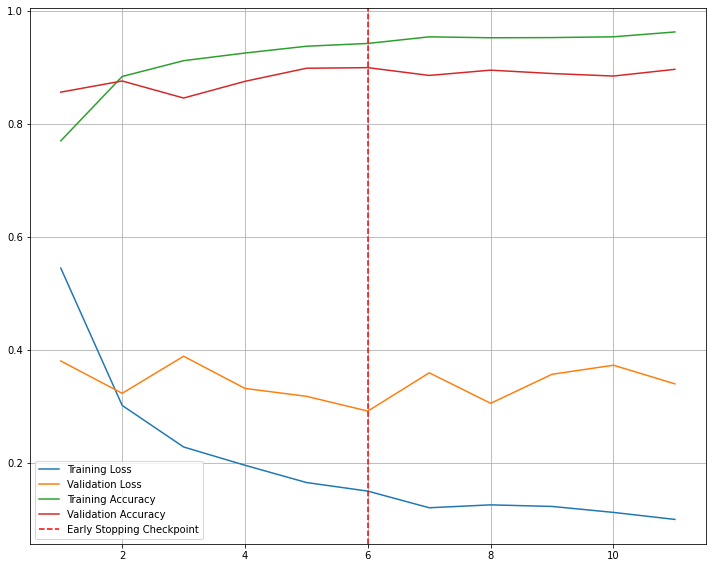

              precision    recall  f1-score   support

     actitic       0.89      0.93      0.91       288
        nail       0.95      0.94      0.95       261
       warts       0.90      0.87      0.88       272

    accuracy                           0.91       821
   macro avg       0.91      0.91      0.91       821
weighted avg       0.91      0.91      0.91       821



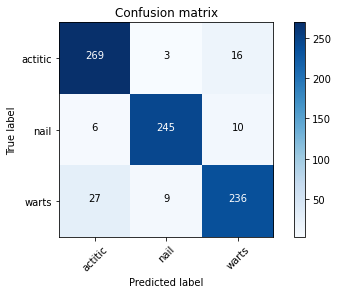

In [ ]:
trained_model.load_state_dict(torch.load('/content/drive/MyDrive/MQ ICT/Densenet/earlyStopping/current_checkpoint_augmentation.pt'))
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')
plt.plot(range(1,len(avg_train_acc)+1),avg_train_acc, label='Training Accuracy')
plt.plot(range(1,len(avg_valid_acc)+1),avg_valid_acc,label='Validation Accuracy')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

#plt.xlabel('epochs')
#plt.ylabel('loss')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools

def plot_cf_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

trained_model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(data_loaders['test']):
        images, labels = data
        N = images.size(0)
        outputs = trained_model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.numpy())
        y_predict.extend(np.squeeze(prediction.numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['actitic', 'nail', 'warts']
plot_cf_matrix(confusion_mtx, plot_labels)

report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

